---
title: "Traffic Density Index Notebook"
format:
  html:
    code-fold: true
jupyter: python3
execute: 
  enabled: false
  eval: false
---

This notebook is used to preprocess PlanetScope imagery which was previously downloaded, and then detect potential vehicle pixels, as well as calculate a Traffic Density Index (TDI) for all images in the time series.

In [2]:
import os
import warnings
import pickle
from pathlib import Path
import subprocess
import rasterio as rio
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import numpy as np
import plotly.express as px
from skimage import morphology
from skimage.measure import label

# Set up paths and read in files for subsequent processing
The variables specified here are used in each of the subsequent stages in the program, so make sure to run this cell before running any subsequent code, even if you are resuming the process at a later stage (i.e. resuming from Stage 3).

In [3]:
aoi_name = "BeitBridge" # Name for AOI

#Main input filepath. All other files and folders should be nested under this one 
# (aside from the road geometry file specified below)
out_path = Path(f"../../data/tdi_demo_files/{aoi_name}")
out_path = out_path.resolve()

#Road and parking lot geometry file for clipping tdi outputs
road_geom_file = Path("../../data/processed/beitbridge_road_mask.gpkg")
road_geom_file = road_geom_file.resolve()

# Folder containing images downloaded using the skywatch-api-notebook
# If images were downloaded in multiple batches, make sure all desired images are located
# within the folder specified here (nested subdirectories are ok)
img_path = out_path.joinpath("images") 

# Directory containing pickle files with image dataframes (generated during image download stage of 
# skywatch-api-notebook If images were downloaded in multiple stages (i.e. multiple date ranges), 
# ensure dataframe pickle files for each set of downloads are present in this folder.
img_df_path = out_path.joinpath("download_dataframes") 

outpath_aligned = out_path.joinpath("processed_images") #Output path for co-aligned images
outpath_aligned.mkdir(parents=True, exist_ok=True)

outpath_tdi = out_path.joinpath("tdi_outputs") #Output directory for TDI file outputs
outpath_tdi.mkdir(parents=True, exist_ok=True)

# Select subset of image bands or run all bands. Options are 'allbands' 
# to use all bands, or '4band' to only process BGRN
band_subset = 'allbands' 

# Size of kernel to use for tophat filtering. Options are 3, 5, and 7. 
# Larger kernels will detect larger pixel groupings.
kernel_size=7 

# Sieve threshold for filtering boolean detection arrays. Groups of detection pixels 
# smaller than the threshold are removed
sieve_thresh = 5 
# Minimum threshold used for vehicle detections from tophat filter array. 
# Program will iteratively use smaller threshold values down to the value specified here.
min_thresh=0.015

In [4]:
# Read in image dataframe(s). If multiple dataframes, put them all together into one.
img_df_pickle_files = list(img_df_path.glob("*_download_df.pkl"))

if len(img_df_pickle_files) > 1:
    img_df_list = []
    for picklefile in img_df_pickle_files:
        img_df_temp = pd.read_pickle(picklefile)
        img_df_list.append(img_df_temp)

    img_df = pd.concat(img_df_list)
    img_df.sort_values(by=['date'], inplace=True)
    img_df.reset_index(drop=True, inplace=True)

else:
    picklefile = img_df_pickle_files[0]
    img_df = pd.read_pickle(picklefile)

# Stage 1: Align Images
This section of the notebook is to take the PlanetScope images downloaded using the skywatch api notebook and resample them to a common pixel grid. <br>
Note: this step should only need to be run one time.

In [5]:
# Find all image files in image directory.
image_files = list(img_path.rglob("*_analytic.tif"))

In [ ]:
def find_im_file(image_files, img_name):
    """
    Finds an image file in a list of file paths by matching an input image name.

    Params:
    ---------------------
    image_files: list
        list of 
    img_name: str
        base name of the image file
    
    Returns:
    ---------------------
    img_file: pathlib path object
        file path of the image file
    img_exists: bool
        boolean variable stating whether the target file exists
    """
    
    im_name_flist = [im for im in image_files if img_name in str(im)]

    if len(im_name_flist) == 1:
        img_file = im_name_flist[0]
        img_exists = True
    elif len(im_name_flist) == 0:
        img_file = ""
        img_exists = False
    
    return img_file, img_exists

def resample_image(base_img, warp_imgname, out_name):
    """
    Function to resample an image to match the base image

    Params:
    ---------------------
    base_img: rasterio dataset
        base image to be aligned to
    warp_imgname: pathlib Path
        path to the image to be resampled.
    out_name: pathlib Path
        output path for resampled image
    """
    
    srs = base_img.crs.to_string()
    pixelsize_x, pixelsize_y = base_img.res
    bbox = base_img.bounds

    #First step: create temp file using gdalwarp which resamples the target image to match the base image
    cmd = f"gdalwarp -t_srs {srs} -tap -tr {pixelsize_x} {pixelsize_y} -r near -te {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} -te_srs {srs} -of vrt {warp_imgname} {out_name}.vrt -overwrite"
    subprocess.check_output(cmd, shell=True)

    #Second step: use gdal_translate to compress the temp file into the final output
    cmd2 = f"gdal_translate -co compress=LZW {out_name}.vrt {out_name}.tif"
    subprocess.check_output(cmd2, shell=True)

    os.remove(f"{out_name}.vrt") #Delete temp file

#Set up a base image to resample everything to match. It selects the first image with 100% AOI coverage to use as the base image
full_cover_img_df = img_df.loc[img_df["aoi_coverage"] == 100]
base_index = 0
base_imgname = full_cover_img_df.iloc[base_index]["product_name"]
base_img_file, base_img_exists = find_im_file(image_files, base_imgname)

if not base_img_exists:
    base_index += 1
    while not base_img_exists:
        base_imgname = full_cover_img_df.iloc[base_index]["product_name"]
        base_img_file, base_img_exists = find_im_file(image_files, base_imgname)
        base_index +=1

base_img = rio.open(base_img_file)

#Iterate through all the images in the img_df dataframe and resample to match the base image
for index, row in img_df.iterrows():
    img_name = row["product_name"]    
    img_file, img_exists = find_im_file(image_files, img_name)
    if not img_exists:
        print(f"Warning: No file found for image: {img_name}. Skipping")
        continue
    img_processedname = outpath_aligned.joinpath(f"{img_name}_aligned")
    resample_image(base_img, img_file, img_processedname)
    print(f"finished resampling image: {img_name}")    

# Stage 2: Compute Reference Median Image
This section of the notebook is used to create a median image from all the aligned images. Note: this section should only need to be run one time.

In [ ]:
# Iterate through all co-registered images and stack them into a big xarray
datasets = []
date_list = []
for index, row in img_df.iterrows():
    img_name = row["product_name"]
    img_date = row['datestr']
    img_file = outpath_aligned.joinpath(f"{img_name}_aligned.tif")
    if not Path.exists(img_file):
        print(f"Warning: No file found for image: {img_name}. Skipping")
        continue
    img_arr = rioxr.open_rasterio(img_file)
    datasets.append(img_arr)
    date_list.append(img_date)

time_var = xr.Variable('time', date_list)
combined_arr = xr.concat(datasets, dim=time_var)
combined_arr = combined_arr.chunk({'time': 1})

In [8]:
# Calculate the pixel and band-wise median from the stacked xarray
median_arr = combined_arr.median(dim='time').compute()

In [9]:
# Outputs temporary median file 
temp_median_file = outpath_aligned.joinpath("median_temp.tif")
median_arr.rio.to_raster(raster_path=temp_median_file)

# Compresses temp median file into final median file. Delete temp file
median_file = outpath_aligned.joinpath("median_image.tif")
cmd = f"gdal_translate -a_nodata 0 -co compress=LZW {temp_median_file} {median_file}"
subprocess.check_output(cmd, shell=True)
os.remove(temp_median_file)

# Stage 3: Tophat filtering, vehicle detection, & computing TDI
This section of the notebook performs the tophat filtering and outputs the final vehicle detections. If Stage 1 and 2 have already been run, start here.

### Function definitions

In [10]:
def export_xarray(export_arr, ref_arr, xr_filename):
    """
    Function used to convert a numpy array to an xarray and export it
    
    Params:
    ---------------------
    export_arr: numpy array
        array to be exported
    ref_arr: xarray data array
        reference xarray to be used to set up the output
    xr_filename: pathlib Path
        filepath for the output file
    """

    coords = {'x': ref_arr.coords['x'].to_numpy(), 'y': ref_arr.coords['y'].to_numpy()}
    export_xr = xr.DataArray(export_arr, coords=coords, dims=('y', 'x'))

    export_xr.rio.write_crs(4326, inplace=True)
    export_xr.rio.to_raster(raster_path=xr_filename) 

def get_kernel(size):
    """
    Function defines kernels for multi-directional tophat filtering based on specified kernel size.

    Params:
    ---------------------
    size: int
        size for the tophat kernel. Options are 3, 5, and 7 currently.
    
    Returns:
    ---------------------
    kernel_dict: dict
        dictionary with tophat kernels
    """
    
    if size == 3:
        kernel_0 = np.array([[0,0,0],
                             [1,1,1],
                             [0,0,0]])
        kernel_45 = np.array([[1,0,0],
                              [0,1,0],
                              [0,0,1]])
        kernel_90 = np.array([[0,1,0],
                              [0,1,0],
                              [0,1,0]])
        kernel_135 = np.array([[0,0,1],
                               [0,1,0],
                               [1,0,0]])
    
    if size == 5:
        kernel_0 = np.array([[0,0,0,0,0],
                             [0,0,0,0,0],
                             [1,1,1,1,1],
                             [0,0,0,0,0],
                             [0,0,0,0,0]])
        kernel_45 = np.array([[1,0,0,0,0],
                              [0,1,0,0,0],
                              [0,0,1,0,0],
                              [0,0,0,1,0],
                              [0,0,0,0,1]])
        kernel_90 = np.array([[0,0,1,0,0],
                              [0,0,1,0,0],
                              [0,0,1,0,0],
                              [0,0,1,0,0],
                              [0,0,1,0,0]])
        kernel_135 = np.array([[0,0,0,0,1],
                               [0,0,0,1,0],
                               [0,0,1,0,0],
                               [0,1,0,0,0],
                               [1,0,0,0,0]])
    if size == 7:
        kernel_0 = np.array([[0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0],
                             [1,1,1,1,1,1,1],
                             [0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0]])
        kernel_45 = np.array([[1,0,0,0,0,0,0],
                              [0,1,0,0,0,0,0],
                              [0,0,1,0,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,0,1,0,0],
                              [0,0,0,0,0,1,0],
                              [0,0,0,0,0,0,1]])
        kernel_90 = np.array([[0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0],
                              [0,0,0,1,0,0,0]])
        kernel_135 = np.array([[0,0,0,0,0,0,1],
                               [0,0,0,0,0,1,0],
                               [0,0,0,0,1,0,0],
                               [0,0,0,1,0,0,0],
                               [0,0,1,0,0,0,0],
                               [0,1,0,0,0,0,0],
                               [1,0,0,0,0,0,0]])

    kernel_dict = {'kernel_0': kernel_0, 'kernel_45': kernel_45, 'kernel_90': kernel_90, 'kernel_135': kernel_135}

    return kernel_dict

def calc_tophat_band(band_arr, kernel_size, tophat_type):
    """
    Computes multiple tophat filters for a specific difference band (difference between target image
    band and median image band). Returns the minimum tophat value from the multi-directional filtering.

    Params:
    ---------------------
    band_arr: xarray data array
        array for the specified band
    kernel_size: int
        size of kernel to use for tophat filtering
    tophat_type: str
        type of tophat filter to use. Options are "white" and "black"

    Returns:
    ---------------------
    min_tophat: xarray data array
        pixel-wise minimum of all tophat kernels
    """

    #Get tophat filter kernels for specified kernel size
    kernel_dict = get_kernel(size=kernel_size)
    
    tophat_arrlist = []

    #Run selected tophat filter type for every tophat kernel on diff image. Append to list
    for key, val in kernel_dict.items():
        if tophat_type=='white':
            tophat_arr = morphology.white_tophat(band_arr, footprint=val)
        if tophat_type=='black':
            tophat_arr = morphology.black_tophat(band_arr, footprint=val)
        tophat_arrlist.append(tophat_arr)

    #Create stacked tophat xarray from list of tophat filters
    tophat_combine = np.array(tophat_arrlist)
    tophat_combine_coords = {'x': band_arr.coords['x'].to_numpy(), 'y': band_arr.coords['y'].to_numpy()}
    tophat_combine_xr = xr.DataArray(tophat_combine, coords=tophat_combine_coords, dims=('band', 'y', 'x'))
    
    #Compute pixel-wise minimum tophat value and return
    min_tophat = tophat_combine_xr.min(dim='band')

    return min_tophat

def calc_diff(band_arr, med_arr):
    """
    Computes difference between band array from target image and corresponding
    band from median image.

    Params:
    ---------------------
    band_arr: xarray data array
        band array from target image
    med_arr: xarray data array
        band array from median image
    
    Returns:
    ---------------------
    diff_arr: numpy array
        array of pixel differences between band_arr and med_arr
    """

    diff_arr = band_arr.to_numpy() - med_arr.to_numpy()

    return diff_arr

def run_tophat_filter(img_arr, median_arr, sat_type, band_subset, kernel_size):
    """
    Function to perform tophat filtering on an image. Iterates through image bands, computes
    difference between the target image band and the median image band, and runs tophat filtering
    function (runs both "black" and "white" tophat filters). Once tophat filtering has been completed
    for all bands, the maximum of all of the individual tophat filters for all bands is computed for each
    tophat filter type (black and white).

    Params:
    ---------------------
    img_arr: xarray data array
        xarray data array for the target image
    median_arr: xarray data array
        xarray data array for the median image
    sat_type: str
        type of satellite that acquired the image
    band_subset: str
        subset of image bands to use for superdove. Options are "allbands" to use all 8 superdove 
        bands, or "4band" to use only the BGRN bands. If satellite type is not superdove, the 4
        BGRN bands are used by default.
    kernel_size: int
        size of kernel to use for tophat filtering
    
    Returns:
    ---------------------
    tophat_dict: dict
        dictionary containing numpy arrays for the two final tophat filters for the target image (black and white)
    """

    tophat_typelist=['black', 'white']
    band_index_dict = {'allbands': [0,1,2,3,4,5,6,7], '4band': [1,3,5,7]}

    # If images are from super dove satellites, bands selected based on band_subset variable.
    # For dove-classic and dove-r, all 4 BGRN bands are used.
    if sat_type == 'superdove':
        band_indices = band_index_dict[band_subset]
    else: band_indices = [0,1,2,3]

    tophat_dict = {}

    #Iterate through image bands and run tophat filter processes for each tophat type (white and black)
    #1. Create difference band
    #2. Run multi-directional tophat filter function
    #3. Calculate pixel-wise maximum tophat value from all bands
    #4. Return dict containing max tophat bands for both white and black tophat filters
    for tophat_type in tophat_typelist:
        tophat_minlist = []
        for i in range(0, len(img_arr)):
            if i not in band_indices:
                continue
            band_xr = img_arr[i]
            diff_arr = calc_diff(band_xr, median_arr[i])
            diff_xr = xr.DataArray(diff_arr, coords=band_xr.coords, dims=band_xr.dims, attrs=band_xr.attrs)
            band_tophat = calc_tophat_band(diff_xr, kernel_size, tophat_type)
            tophat_minlist.append(band_tophat)

        min_tophat_combine_xr = xr.concat(tophat_minlist, dim='band')
        tophat_final = min_tophat_combine_xr.max(dim='band')
        tophat_dict[tophat_type] = tophat_final

    return tophat_dict

def combine_filters(tophat_white_arr, tophat_black_arr):
    """
    Combine the black and white tophat filters for the target image into a single filter which is
    the pixel-wise maximum of both.

    Params:
    ---------------------
    tophat_white_arr: numpy array
        white tophat filter array
    tophat_black_arr: numpy array
        black tophat filter array

    Returns:
    ---------------------
    max_tophat: xarray data array
        combined tophat filter array
    """
    
    combined_tophat = xr.concat([tophat_white_arr, tophat_black_arr], dim='band')
    max_tophat = combined_tophat.max(dim='band')
    max_tophat.rio.write_crs(4326, inplace=True)

    return max_tophat

def clip_tophat(max_tophat, clip_geom):
    """
    Clips tophat filter to road and parking area geometry

    Params:
    ---------------------
    max_tophat: xarray data array
        tophat filter array
    clip_geom: geopandas geodataframe
        geodataframe containing the clipping geometry

    Returns:
    ---------------------
    clipped: xarray data array
        clipped tophat filter array
    """

    clipped = max_tophat.rio.clip(clip_geom.geometry.values, clip_geom.crs)

    return clipped

def apply_threshold(max_tophat, threshold):
    """
    Function to apply a threshold to a tophat filter array to create a boolean array.

    Params:
    ---------------------
    max_tophat: xarray data array
        tophat filter array
    threshold: float
        threshold to apply to tophat array

    Returns:
    tophat_bool: numpy array
        boolean tophat array
    ---------------------
    """
    
    tophat_bool = xr.where(max_tophat >= threshold, 1, 0)
    tophat_bool = tophat_bool.astype(np.int8).to_numpy()
    
    return tophat_bool

def sieve_bool_filter(tophat_bool, sieve_thresh):
    """
    Apply sieving to boolean tophat array to filter out small objects.

    Params:
    ---------------------
    tophat_bool: numpy array
        boolean tophat array
    sieve_thresh: int
        threshold to use for sieving. Objects smaller than the threshold are removed.

    Returns:
    ---------------------
    tophat_sieve: numpy array
        sieved boolean tophat array
    """
    
    labelled = label(tophat_bool)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tophat_sieve = morphology.remove_small_objects(labelled, min_size=sieve_thresh, connectivity=1)
        
    tophat_sieve = np.where(tophat_sieve > 0, 1, 0)
    tophat_sieve = tophat_sieve.astype(np.int8)
    
    return tophat_sieve

def threshold_tophat(clipped_tophat, min_thresh, sieve_thresh):
    """
    Function to apply thresholding to the image tophat filters to create boolean detection arrays.
    Initiallty uses the maximum value from the tophat array and iteratively reduces until it reaches 
    the specified minimum threshold value. After each iteration the results from the previous iteration 
    is subtracted from the current one, and sieving is applied to remove small objects. The sieved 
    filter array is then added together with the previous results to create a combined array.
    
    Note this iterative approach does not seem to add much value over just using the minimum value right 
    from the get-go, but does reduce the number of stray pixels and makes the detections possibly a bit more cohesive.
    The iterative approach was implemented to adhere to the workflow outlined in Chen et al. 2021

    Params:
    ---------------------
    clipped_tophat: xarray data array
        clipped tophat filter array
    min_thresh: float
        minimum threshold value to use to create boolean vehicle detection array
    sieve_thresh: int
        minimum object size (in pixels). Objects smaller than the specified size are removed

    Returns:
    ---------------------
    final_bool: numpy array
        boolean vehicle detection array

    """
    
    max_thresh = clipped_tophat.max()
    current_thresh = max_thresh
    thresh_multiplier = 0.9

    if current_thresh < min_thresh:
        print(f'Max tophat value less than the specified minimum threshold setting: max tophat val = {max_thresh}; min threshold = {min_thresh}')
        raise KeyboardInterrupt

    first_iter = True
    while current_thresh >= min_thresh:
        if first_iter:
            tophat_bool = apply_threshold(clipped_tophat, current_thresh)
            tophat_bool = sieve_bool_filter(tophat_bool, sieve_thresh)
            previous_bool = np.copy(tophat_bool)
            first_iter = False
        else:
            tophat_bool = apply_threshold(clipped_tophat, current_thresh)
            tophat_bool = tophat_bool - previous_bool
            tophat_bool = sieve_bool_filter(tophat_bool, sieve_thresh)
            previous_bool = previous_bool + tophat_bool
        
        current_thresh = current_thresh * thresh_multiplier

    if current_thresh < min_thresh:
        current_thresh = min_thresh
        tophat_bool = apply_threshold(clipped_tophat, current_thresh)
        tophat_bool = tophat_bool - previous_bool
        tophat_bool = sieve_bool_filter(tophat_bool, sieve_thresh)
        previous_bool = previous_bool + tophat_bool

    final_bool = np.copy(previous_bool)

    return final_bool

def calc_tdi(clipped_band, detection_arr):
    """
    Calculates the Traffic Density Index (TDI) by dividing the number of vehicle detection pixels
    by the total number of pixels within the road and parking lot geometry mask.

    Params:
    ---------------------
    clipped_band: xarray data array
        band from target image clipped to road geometry
    detection_arr: numpy array
        boolean vehicle detection array

    Returns:
    ---------------------
    tdi: float
        computed tdi value
    """

    total_pixels = np.count_nonzero(clipped_band.to_numpy())
    detection_pixels = np.count_nonzero(detection_arr)

    tdi = (detection_pixels / total_pixels) * 100.0

    return tdi

## Tophat filtering code execution begins here

In [11]:
# Read in the median image file
median_file = outpath_aligned.joinpath("median_image.tif")
median_arr = rioxr.open_rasterio(median_file)

In [12]:
# Create output directory for the tophat rasters and boolean vehicle detection rasters
tophat_outpath = outpath_tdi.joinpath("tophat_rasters")
tophat_outpath.mkdir(parents=True, exist_ok=True)

detection_outpath = outpath_tdi.joinpath("detection_rasters")
detection_outpath.mkdir(parents=True, exist_ok=True)

In [ ]:
# To process a single image, set a date in the "select_date" variable. Otherwise leave it set to None to process all images
select_date = None
# select_date = "2022-12-24"

# Read in road clipping geometry
road_geom_gpd = gpd.read_file(road_geom_file)

tdi_list = [] # List of TDI values. Each TDI value from each image is appended to this list
missing_imgs = [] # List of missing images. Used to filter final TDI dataframe.
# Iterate through all images in img_df and run vehicle detection and tdi calculation. If "select_date" variable set, will only process selected image
for index, content in img_df.iterrows():

    img_name = content["product_name"]
    img_date = content['datestr']
    sat_type = content['sat_type']

    if select_date and img_date != select_date:
        continue

    print(f'Calculating TDI for image: {img_name}')

    img_file = outpath_aligned.joinpath(f"{img_name}_aligned.tif")
    if not Path.exists(img_file):
        print(f"Warning: No file found for image: {img_name}. Skipping")
        missing_imgs.append(img_name)
        continue

    img_arr = rioxr.open_rasterio(img_file)
    
    #Create tophat filters for target image
    tophat_dict = run_tophat_filter(img_arr, median_arr, sat_type, band_subset, kernel_size)

    #Combine white and black tophat filters and save to file
    max_tophat = combine_filters(tophat_dict['white'], tophat_dict['black'])
    tophat_tempname = tophat_outpath.joinpath(f"{img_name}_tophat_temp.tif")
    tophat_combined_fname = tophat_outpath.joinpath(f"{img_name}_tophat_raster.tif")
    max_tophat.rio.write_crs(4326, inplace=True)
    max_tophat.rio.to_raster(raster_path=tophat_tempname) 
    cmd = f"gdal_translate -co compress=LZW {tophat_tempname} {tophat_combined_fname}"
    subprocess.check_output(cmd, shell=True)

    #Clip tophat array to road geometry
    clipped_tophat = clip_tophat(max_tophat, road_geom_gpd)
    
    #Create boolean vehicle detection arry from clipped tophat array
    final_bool = threshold_tophat(clipped_tophat, min_thresh, sieve_thresh)

    #Output boolean vehicle detection array
    bool_tempname = detection_outpath.joinpath(f"{img_name}_vehicle_detection_temp.tif")
    final_bool_fname = detection_outpath.joinpath(f"{img_name}_vehicle_detection_raster.tif")
    export_xarray(final_bool, clipped_tophat, bool_tempname)
    cmd = f"gdal_translate -a_nodata 0 -co compress=LZW {bool_tempname} {final_bool_fname}"
    subprocess.check_output(cmd, shell=True)

    #Calculate TDI
    clipped_img_band = img_arr[1].rio.clip(road_geom_gpd.geometry.values, road_geom_gpd.crs)
    tdi = calc_tdi(clipped_img_band, final_bool)
    tdi_list.append(tdi)

    os.remove(tophat_tempname)
    os.remove(bool_tempname)

## Creating TDI dataframe and outputting to a CSV file and creating chart.

In [14]:
tdi_df = img_df.copy()
tdi_df = tdi_df[~tdi_df['product_name'].isin(missing_imgs)]
tdi_df['tdi'] = tdi_list
tdi_df.drop(columns=["search_id", "id", "source", "area_sq_km", 
                     "cost", "preview", "preview_html", "pl_id", "pl_status"], inplace=True)
tdi_df.reset_index(drop=True, inplace=True)

min_date = tdi_df['datestr'].min()
max_date = tdi_df['datestr'].max()
tdi_csv_file = outpath_tdi.joinpath(f"{aoi_name}_TDI_DF_{min_date}_to_{max_date}.csv")
tdi_df.to_csv(tdi_csv_file)

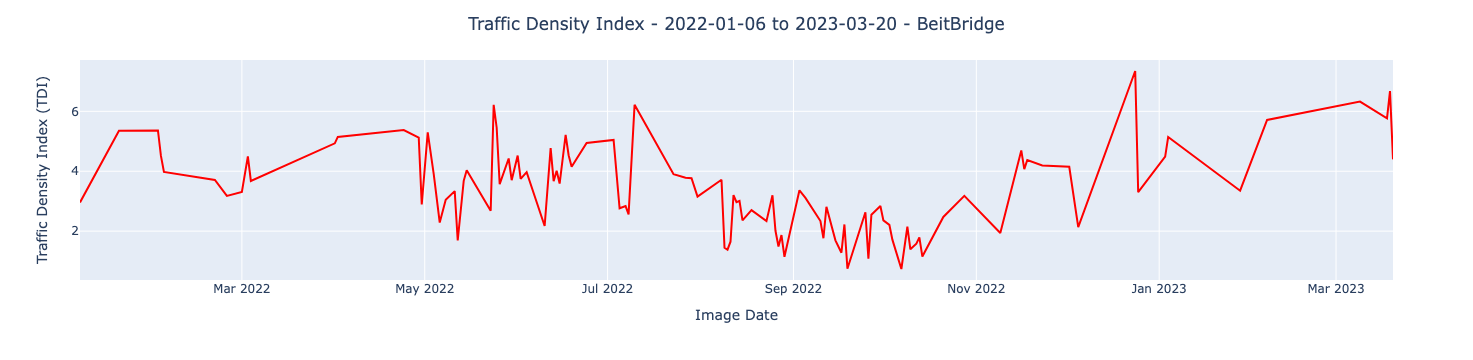

In [15]:
# Creating TDI time series line chart
tdi_fig = px.line(tdi_df, x='date', y='tdi', color_discrete_map={'tdi': 'red'})
tdi_fig.update_traces(line_color='red', line_width=2)
tdi_fig.update_layout(title_text=f"Traffic Density Index - {min_date} to {max_date} - {aoi_name}", title_x=0.5, yaxis_title="Traffic Density Index (TDI)", xaxis_title="Image Date")

fignamestr = f"{aoi_name}_TDI_Chart_{min_date}_to_{max_date}"
tdi_out_png = outpath_tdi.joinpath(f"{fignamestr}.png")
tdi_out_html = outpath_tdi.joinpath(f"{fignamestr}.html")
tdi_fig.write_image(tdi_out_png)
tdi_fig.write_html(tdi_out_html)
tdi_fig.show()